ЛР2: Векторизация текстов и PCA

In [ ]:
%pip install --upgrade setuptools
%pip install pymorphy2 pymorphy2-dicts-ru

In [ ]:
import os
import re
import warnings

import pandas as pd
import numpy as np

from collections import Counter
from operator import index

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import pymorphy2

warnings.filterwarnings('ignore', category=RuntimeWarning)

In [ ]:
import subprocess

REPO_URL = "https://github.com/your-username/mephi-data-analysis-part2-2025-fall.git"
REPO_DIR = "mephi-data-analysis-part2-2025-fall"

if not os.path.exists(REPO_DIR):
    subprocess.run(["git", "clone", REPO_URL])

DATA_PATH = os.path.join(REPO_DIR, "solutions", "LR-s", "LR2", "data_lab_2.csv")

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Не найден файл данных: {DATA_PATH}")

df = pd.read_csv(DATA_PATH, index_col="Unnamed: 0.1")
df = df.drop(columns=["Unnamed: 0"])

print("Форма датафрейма:", df.shape)
print("Колонки:", list(df.columns))
print("Первые строки:")
df.head(3)

Форма датафрейма: (139, 6)
Колонки: ['author_link', 'author_name', 'stars', 'date', 'title', 'body']
Первые строки:


,author_link,author_name,stars,date,title,body
0,/users/ksellena,ksellena,5,2022-12-16T13:48:16+01:00,\nАватар: Путь воды → 13 лет ожиданий и вот он...,\nПривет! Наконец-то он вышел! Долгожданное пр...
1,/users/nataliya34,nataliya34,2,2022-12-17T11:26:17+01:00,"\nЭто провал, Карл!","\nПусть я буду той Бабой Ягой, которая против...."
2,/users/gala58-0,Tovaroved007,2,2023-01-09T11:46:05+01:00,"\nАватар:Путь воды - фильм, который опоздал на...","\nПомню как в 2009 году меня поразил фильм ""Ав..."


In [ ]:
TEXT_COLUMN = "body"
if TEXT_COLUMN not in df.columns:
    raise KeyError(f"Ожидалась колонка '{TEXT_COLUMN}' в данных. Доступные колонки: {list(df.columns)}")

WORD_RE = re.compile(r"[a-zA-Zа-яА-ЯёЁ]+", re.UNICODE)

def tokenize_to_words(text: str) -> list:
    if not isinstance(text, str):
        text = "" if pd.isna(text) else str(text)
    return WORD_RE.findall(text.lower())

corpus_tokens = df[TEXT_COLUMN].apply(tokenize_to_words)

def count_tokens(tokens: list) -> dict:
    freq: dict = {}
    for tok in tokens:

        prev = freq.get(tok)
        if prev is None:
            freq[tok] = 1
        else:
            freq[tok] = prev + 1
    return freq

per_doc_freq = corpus_tokens.apply(count_tokens)


corpus_freq: dict = {}
for freq_map in per_doc_freq:
    for tok, c in freq_map.items():
        prev = corpus_freq.get(tok)
        if prev is None:
            corpus_freq[tok] = c
        else:
            corpus_freq[tok] = prev + c


vocabulary = sorted(corpus_freq.keys(), key=lambda t: (-corpus_freq[t], t))


rows = []
for freq_map in per_doc_freq:
    row = {tok: freq_map.get(tok, 0) for tok in vocabulary}
    rows.append(row)

dtm_re = pd.DataFrame.from_records(rows)

print("dtm_re shape:", dtm_re.shape)
print("Пример колонок:", list(dtm_re.columns)[:20])
dtm_re.head(3)


dtm_re shape: (139, 10107)
Пример колонок: ['и', 'в', 'не', 'на', 'что', 'фильм', 'я', 'с', 'аватар', 'но', 'как', 'это', 'то', 'воды', 'путь', 'а', 'все', 'фильма', 'очень', 'за']


,и,в,не,на,что,фильм,я,с,аватар,но,...,яркого,яркое,яркость,яркостью,ярок,яростная,ярый,ясна,ёмко,ёх
0,27,14,16,20,12,16,12,9,18,8,...,0,0,0,0,0,0,0,0,0,0
1,10,12,13,9,6,3,7,8,3,1,...,0,0,0,0,0,0,0,0,0,0
2,27,21,21,10,16,7,6,11,5,9,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
per_doc_counter = corpus_tokens.apply(lambda toks: Counter(toks))


total_counter: Counter = Counter()
for c in per_doc_counter:
    total_counter.update(c)

vocabulary_counter = [tok for tok, _ in total_counter.most_common()]


rows_counter = []
for c in per_doc_counter:

    rows_counter.append(dict(c))

dtm_counter = pd.DataFrame.from_records(rows_counter)


if len(dtm_counter.columns) > 0:
    dtm_counter = dtm_counter.reindex(columns=vocabulary_counter).fillna(0)

    try:
        dtm_counter = dtm_counter.astype(int)
    except Exception:
        pass

print("dtm_counter shape:", dtm_counter.shape)
print("Пример колонок:", list(dtm_counter.columns)[:20])
dtm_counter.head(3)

dtm_counter shape: (139, 10107)
Пример колонок: ['и', 'в', 'не', 'на', 'что', 'фильм', 'я', 'с', 'аватар', 'но', 'как', 'это', 'то', 'воды', 'путь', 'а', 'все', 'фильма', 'очень', 'за']


,и,в,не,на,что,фильм,я,с,аватар,но,...,легенда,достойного,увлекают,коленки,довольны,болит,поплакать,переворачивается,ног,закружилась
0,27,14,16,20,12,16,12,9,18,8,...,0,0,0,0,0,0,0,0,0,0
1,10,12,13,9,6,3,7,8,3,1,...,0,0,0,0,0,0,0,0,0,0
2,27,21,21,10,16,7,6,11,5,9,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
texts = df[TEXT_COLUMN].fillna("").astype(str).tolist()

cv = CountVectorizer()
X_cv = cv.fit_transform(texts)
feature_names = cv.get_feature_names_out()

dtm_cv = pd.DataFrame.sparse.from_spmatrix(X_cv, columns=feature_names)

print("dtm_cv shape:", dtm_cv.shape)
print("Пример колонок:", list(feature_names)[:20])
dtm_cv.head(3)

dtm_cv shape: (139, 10179)
Пример колонок: ['000', '000сборы', '03', '075', '10', '100', '1000', '100500', '12', '12рейтинг', '13', '13время', '14', '15', '16', '174', '18', '190', '1917', '192']


,000,000сборы,03,075,10,100,1000,100500,12,12рейтинг,...,яркость,яркостью,ярок,яростная,ярче,ярый,ясна,ясно,ёмко,ёх
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
texts = df[TEXT_COLUMN].fillna("").astype(str).tolist()

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(texts)
feature_names_tfidf = tfidf.get_feature_names_out()

dtm_tfidf = pd.DataFrame.sparse.from_spmatrix(X_tfidf, columns=feature_names_tfidf)

print("dtm_tfidf shape:", dtm_tfidf.shape)
print("Пример колонок:", list(feature_names_tfidf)[:20])
dtm_tfidf.head(3)

dtm_tfidf shape: (139, 10179)
Пример колонок: ['000', '000сборы', '03', '075', '10', '100', '1000', '100500', '12', '12рейтинг', '13', '13время', '14', '15', '16', '174', '18', '190', '1917', '192']


,000,000сборы,03,075,10,100,1000,100500,12,12рейтинг,...,яркость,яркостью,ярок,яростная,ярче,ярый,ясна,ясно,ёмко,ёх
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.036122,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0.026146,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
cols_re = set(dtm_re.columns)
cols_counter = set(dtm_counter.columns)
cols_cv = set(dtm_cv.columns)
cols_tfidf = set(dtm_tfidf.columns)


all_union = cols_re | cols_counter | cols_cv | cols_tfidf
all_intersection = cols_re & cols_counter & cols_cv & cols_tfidf
pairwise = {
    ("re","counter"): len(cols_re & cols_counter),
    ("re","cv"): len(cols_re & cols_cv),
    ("re","tfidf"): len(cols_re & cols_tfidf),
    ("counter","cv"): len(cols_counter & cols_cv),
    ("counter","tfidf"): len(cols_counter & cols_tfidf),
    ("cv","tfidf"): len(cols_cv & cols_tfidf),
}

print("Число токенов (уникальных столбцов):")
print({
    "re": len(cols_re),
    "counter": len(cols_counter),
    "cv": len(cols_cv),
    "tfidf": len(cols_tfidf),
    "union": len(all_union),
    "intersection_all": len(all_intersection),
})
print("Пересечения попарно:", pairwise)


colsum_re = dtm_re.sum(axis=0)
colsum_counter = dtm_counter.sum(axis=0)
colsum_cv = dtm_cv.sparse.to_dense().sum(axis=0) if hasattr(dtm_cv, "sparse") else dtm_cv.sum(axis=0)


common_counts = set(colsum_re.index) & set(colsum_counter.index) & set(colsum_cv.index)
colsum_re_c = colsum_re.loc[sorted(common_counts)]
colsum_counter_c = colsum_counter.loc[sorted(common_counts)]
colsum_cv_c = colsum_cv.loc[sorted(common_counts)]


corr_re_counter = colsum_re_c.corr(colsum_counter_c, method="spearman")
corr_re_cv = colsum_re_c.corr(colsum_cv_c, method="spearman")
corr_counter_cv = colsum_counter_c.corr(colsum_cv_c, method="spearman")

print("Корреляции суммарных частот (Spearman) между счетными матрицами:")
print({
    "re_vs_counter": float(corr_re_counter) if pd.notna(corr_re_counter) else None,
    "re_vs_cv": float(corr_re_cv) if pd.notna(corr_re_cv) else None,
    "counter_vs_cv": float(corr_counter_cv) if pd.notna(corr_counter_cv) else None,
})


df_tfidf = (dtm_tfidf.sparse.to_dense() > 0).sum(axis=0) if hasattr(dtm_tfidf, "sparse") else (dtm_tfidf > 0).sum(axis=0)
df_cv = (dtm_cv.sparse.to_dense() > 0).sum(axis=0) if hasattr(dtm_cv, "sparse") else (dtm_cv > 0).sum(axis=0)

common_df = set(df_tfidf.index) & set(df_cv.index)
df_tfidf_c = df_tfidf.loc[sorted(common_df)]
df_cv_c = df_cv.loc[sorted(common_df)]

corr_df_tfidf_cv = df_tfidf_c.corr(df_cv_c, method="spearman")
print("Корреляция документных частот TF-IDF vs CountVectorizer (Spearman):", float(corr_df_tfidf_cv) if pd.notna(corr_df_tfidf_cv) else None)


summary_df = pd.DataFrame({
    "tokens_count": {
        "re": len(cols_re),
        "counter": len(cols_counter),
        "cv": len(cols_cv),
        "tfidf": len(cols_tfidf),
        "union": len(all_union),
        "intersection_all": len(all_intersection),
    }
})
summary_df


Число токенов (уникальных столбцов):
{'re': 10107, 'counter': 10107, 'cv': 10179, 'tfidf': 10179, 'union': 10207, 'intersection_all': 10079}
Пересечения попарно: {('re', 'counter'): 10107, ('re', 'cv'): 10079, ('re', 'tfidf'): 10079, ('counter', 'cv'): 10079, ('counter', 'tfidf'): 10079, ('cv', 'tfidf'): 10179}
Корреляции суммарных частот (Spearman) между счетными матрицами:
{'re_vs_counter': 1.0, 're_vs_cv': 0.9999510370856168, 'counter_vs_cv': 0.9999510370856168}
Корреляция документных частот TF-IDF vs CountVectorizer (Spearman): 1.0


,tokens_count
re,10107
counter,10107
cv,10179
tfidf,10179
union,10207
intersection_all,10079


In [ ]:
X_counts = dtm_counter.values.astype(float)


variances = np.var(X_counts, axis=0)
non_zero_var_mask = variances > 1e-10
X_counts_clean = X_counts[:, non_zero_var_mask]


X_counts_clean = np.nan_to_num(X_counts_clean, nan=0.0, posinf=0.0, neginf=0.0)

print(f"Исходная размерность: {X_counts.shape}")
print(f"После удаления константных признаков: {X_counts_clean.shape}")

pca = PCA(n_components=2, random_state=42)
X_pca_2 = pca.fit_transform(X_counts_clean)


pca_2d_counter = pd.DataFrame(X_pca_2)
pca_2d_counter.columns = ["PC1", "PC2"]

explained_var_ratio_counter = pca.explained_variance_ratio_
print("Explained variance ratio (PC1, PC2):", explained_var_ratio_counter)
print("Суммарная объясненная дисперсия:", float(explained_var_ratio_counter.sum()))




feature_names_clean = dtm_counter.columns[non_zero_var_mask]
loadings_counter = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), index=feature_names_clean)
loadings_counter.columns = ["PC1", "PC2"]

pca_2d_counter.head(3)


Исходная размерность: (139, 10107)
После удаления константных признаков: (139, 10107)
Explained variance ratio (PC1, PC2): [0.49660108 0.10062756]
Суммарная объясненная дисперсия: 0.5972286405406035


,PC1,PC2
0,29.772887,16.199807
1,0.846015,-0.790949
2,25.934451,-3.470175


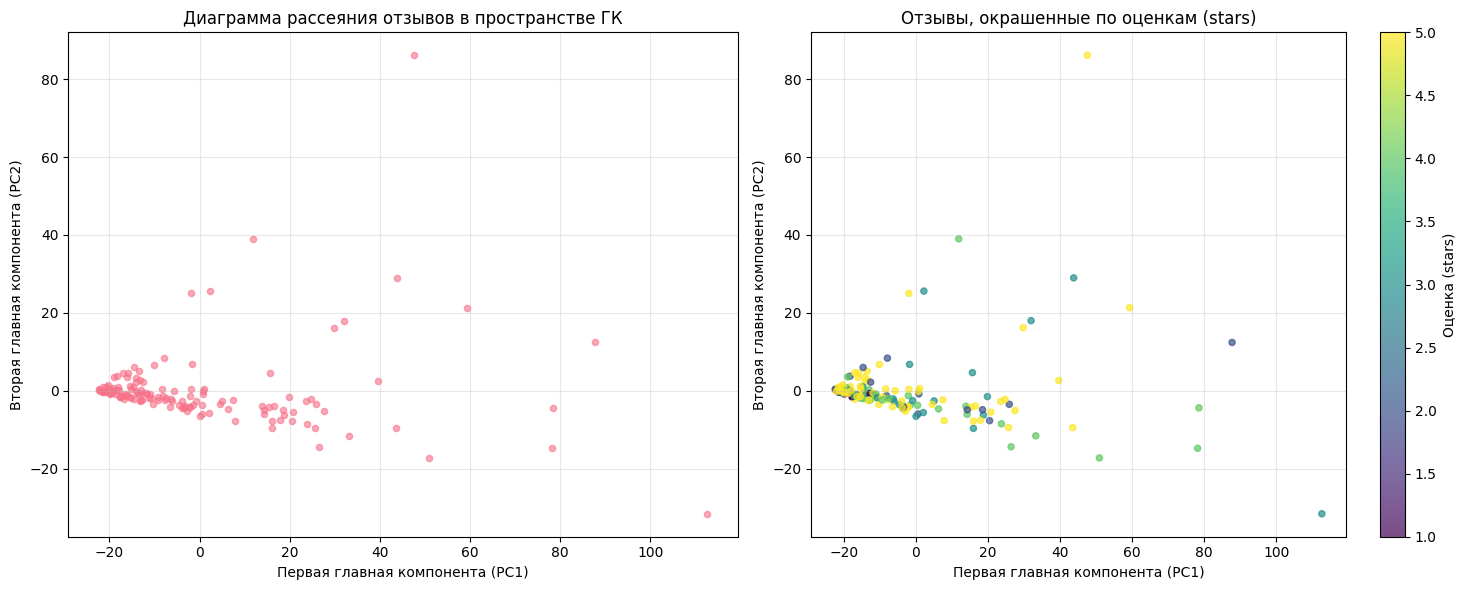

Статистика по главным компонентам:
PC1: мин=-22.350, макс=112.633, среднее=-0.000, стд=23.768
PC2: мин=-31.574, макс=86.141, среднее=-0.000, стд=10.699


In [ ]:
plt.style.use('default')
sns.set_palette("husl")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


ax1.scatter(pca_2d_counter['PC1'], pca_2d_counter['PC2'], alpha=0.6, s=20)
ax1.set_xlabel('Первая главная компонента (PC1)')
ax1.set_ylabel('Вторая главная компонента (PC2)')
ax1.set_title('Диаграмма рассеяния отзывов в пространстве ГК')
ax1.grid(True, alpha=0.3)


if 'stars' in df.columns:

    scatter = ax2.scatter(pca_2d_counter['PC1'], pca_2d_counter['PC2'], 
                         c=df['stars'], cmap='viridis', alpha=0.7, s=20)
    ax2.set_xlabel('Первая главная компонента (PC1)')
    ax2.set_ylabel('Вторая главная компонента (PC2)')
    ax2.set_title('Отзывы, окрашенные по оценкам (stars)')
    ax2.grid(True, alpha=0.3)
    

    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Оценка (stars)')
else:

    ax2.scatter(pca_2d_counter['PC1'], pca_2d_counter['PC2'], alpha=0.6, s=20)
    ax2.set_xlabel('Первая главная компонента (PC1)')
    ax2.set_ylabel('Вторая главная компонента (PC2)')
    ax2.set_title('Диаграмма рассеяния отзывов в пространстве ГК')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("Статистика по главным компонентам:")
print(f"PC1: мин={pca_2d_counter['PC1'].min():.3f}, макс={pca_2d_counter['PC1'].max():.3f}, "
      f"среднее={pca_2d_counter['PC1'].mean():.3f}, стд={pca_2d_counter['PC1'].std():.3f}")
print(f"PC2: мин={pca_2d_counter['PC2'].min():.3f}, макс={pca_2d_counter['PC2'].max():.3f}, "
      f"среднее={pca_2d_counter['PC2'].mean():.3f}, стд={pca_2d_counter['PC2'].std():.3f}")


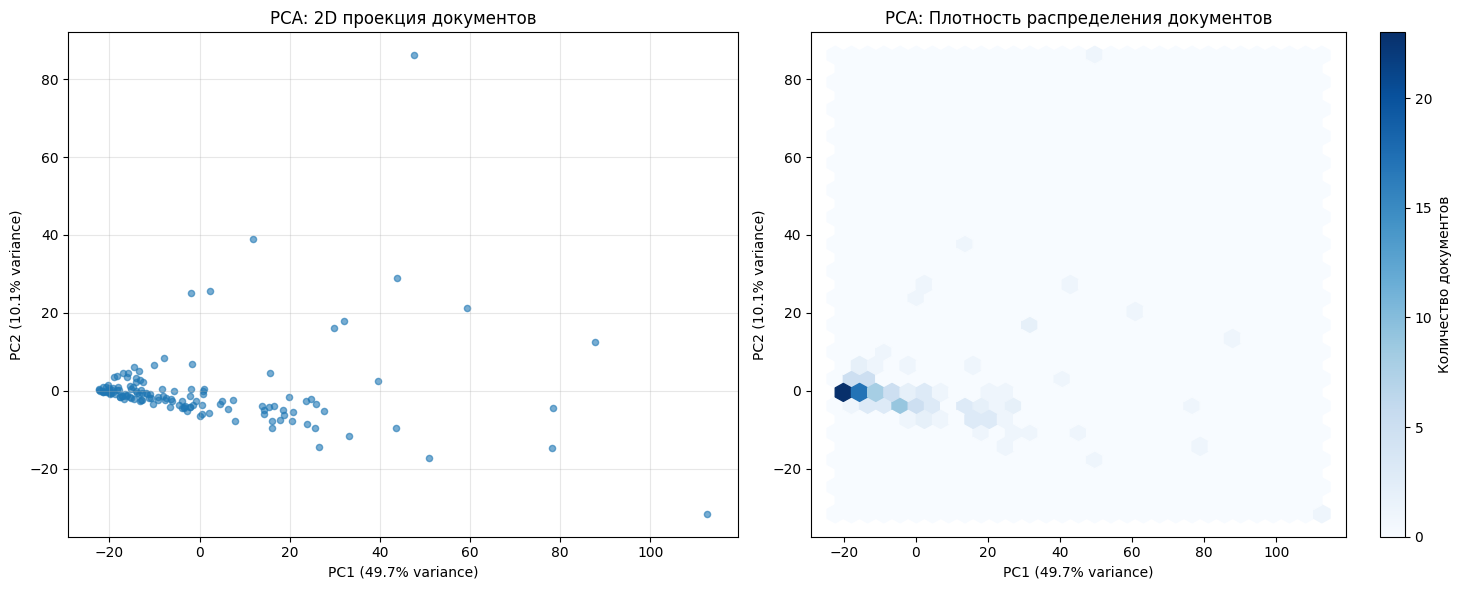

PC1: мин=-22.35, макс=112.63
PC2: мин=-31.57, макс=86.14


In [ ]:
plt.style.use('default')
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].scatter(pca_2d_counter['PC1'], pca_2d_counter['PC2'], alpha=0.6, s=20)
axes[0].set_xlabel(f'PC1 ({explained_var_ratio_counter[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({explained_var_ratio_counter[1]:.1%} variance)')
axes[0].set_title('PCA: 2D проекция документов')
axes[0].grid(True, alpha=0.3)

im = axes[1].hexbin(pca_2d_counter['PC1'], pca_2d_counter['PC2'], gridsize=30, cmap='Blues')
axes[1].set_xlabel(f'PC1 ({explained_var_ratio_counter[0]:.1%} variance)')
axes[1].set_ylabel(f'PC2 ({explained_var_ratio_counter[1]:.1%} variance)')
axes[1].set_title('PCA: Плотность распределения документов')
plt.colorbar(im, ax=axes[1], label='Количество документов')

plt.tight_layout()
plt.show()

print(f"PC1: мин={pca_2d_counter['PC1'].min():.2f}, макс={pca_2d_counter['PC1'].max():.2f}")
print(f"PC2: мин={pca_2d_counter['PC2'].min():.2f}, макс={pca_2d_counter['PC2'].max():.2f}")

=== ИНТЕРПРЕТАЦИЯ ГЛАВНЫХ КОМПОНЕНТ ===

PC1 объясняет 49.7% дисперсии
PC2 объясняет 10.1% дисперсии
Суммарно: 59.7% дисперсии

--- PC1: Топ-20 признаков с положительными нагрузками ---
 1. и                12.7921
 2. в                 8.6802
 3. не                7.8985
 4. на                6.3290
 5. что               4.8235
 6. с                 3.7476
 7. аватар            3.6728
 8. как               3.2097
 9. я                 2.9896
10. воды              2.9307
11. а                 2.9272
12. путь              2.8970
13. но                2.8705
14. то                2.6970
15. фильм             2.6062
16. это               2.5068
17. его               2.1075
18. так               2.0222
19. он                2.0055
20. из                1.7863

--- PC1: Топ-20 признаков с отрицательными нагрузками ---
 1. ждал             -0.0286
 2. великолепный     -0.0201
 3. эмоционально     -0.0187
 4. трогательные     -0.0182
 5. длинный          -0.0180
 6. голова           -0.0169
 

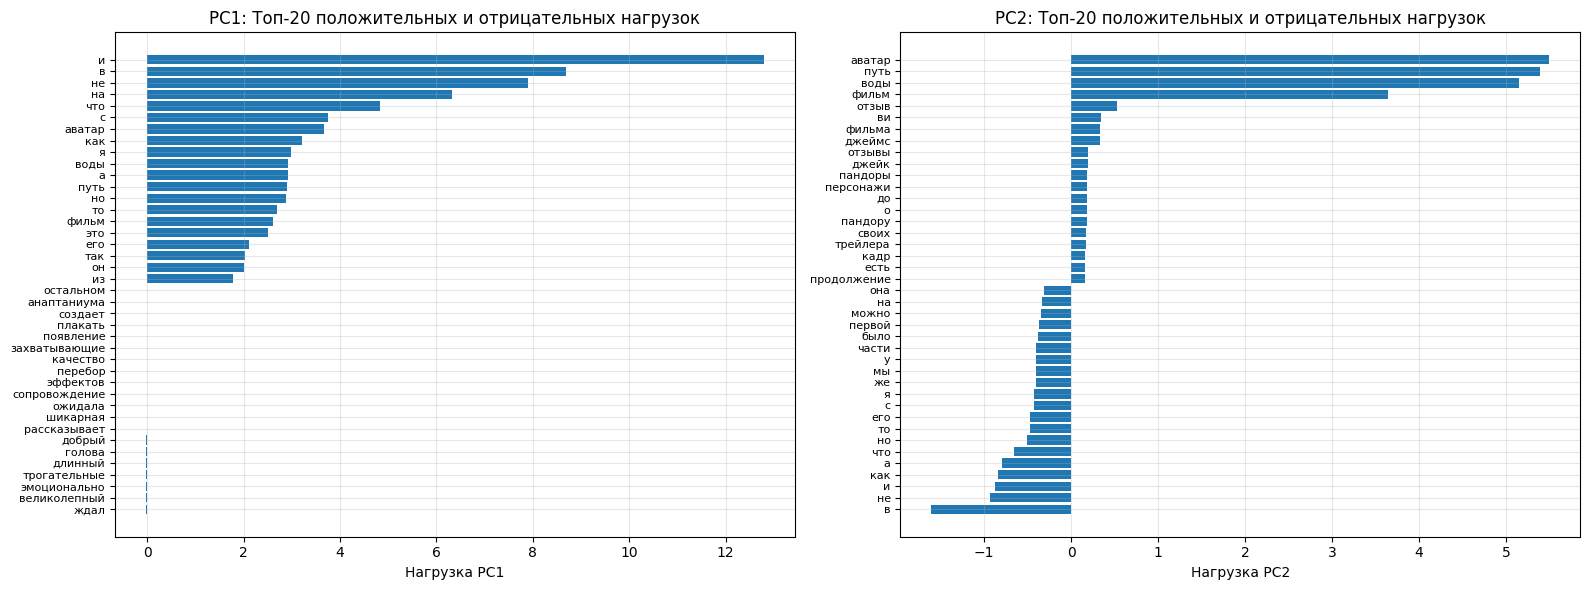


--- КОРРЕЛЯЦИИ С ИСХОДНЫМИ ПРИЗНАКАМИ ---
Корреляции между PC1/PC2 и исходными признаками (топ-10 по |корреляции| с PC1):
              PC1       PC2
и       12.792077 -0.871934
в        8.680180 -1.608848
не       7.898538 -0.937253
на       6.329013 -0.336666
что      4.823473 -0.660997
с        3.747603 -0.429161
аватар   3.672816  5.497794
как      3.209659 -0.838342
я        2.989597 -0.428580
воды     2.930705  5.156275


In [ ]:
n_top = 20

pc1_top = loadings_counter.nlargest(n_top, 'PC1')[['PC1']]
pc1_bottom = loadings_counter.nsmallest(n_top, 'PC1')[['PC1']]

pc2_top = loadings_counter.nlargest(n_top, 'PC2')[['PC2']]
pc2_bottom = loadings_counter.nsmallest(n_top, 'PC2')[['PC2']]

print("=== ИНТЕРПРЕТАЦИЯ ГЛАВНЫХ КОМПОНЕНТ ===")
print(f"\nPC1 объясняет {explained_var_ratio_counter[0]:.1%} дисперсии")
print(f"PC2 объясняет {explained_var_ratio_counter[1]:.1%} дисперсии")
print(f"Суммарно: {explained_var_ratio_counter.sum():.1%} дисперсии")

print(f"\n--- PC1: Топ-{n_top} признаков с положительными нагрузками ---")
for idx, (token, loading) in enumerate(pc1_top.iterrows(), 1):
    print(f"{idx:2d}. {token:15s} {loading['PC1']:8.4f}")

print(f"\n--- PC1: Топ-{n_top} признаков с отрицательными нагрузками ---")
for idx, (token, loading) in enumerate(pc1_bottom.iterrows(), 1):
    print(f"{idx:2d}. {token:15s} {loading['PC1']:8.4f}")

print(f"\n--- PC2: Топ-{n_top} признаков с положительными нагрузками ---")
for idx, (token, loading) in enumerate(pc2_top.iterrows(), 1):
    print(f"{idx:2d}. {token:15s} {loading['PC2']:8.4f}")

print(f"\n--- PC2: Топ-{n_top} признаков с отрицательными нагрузками ---")
for idx, (token, loading) in enumerate(pc2_bottom.iterrows(), 1):
    print(f"{idx:2d}. {token:15s} {loading['PC2']:8.4f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

pc1_combined = pd.concat([pc1_top, pc1_bottom])
pc1_combined = pc1_combined.sort_values(by='PC1', ascending=True)
axes[0].barh(range(len(pc1_combined)), pc1_combined['PC1'])
axes[0].set_yticks(range(len(pc1_combined)))
axes[0].set_yticklabels(pc1_combined.index, fontsize=8)
axes[0].set_xlabel('Нагрузка PC1')
axes[0].set_title(f'PC1: Топ-{n_top} положительных и отрицательных нагрузок')
axes[0].grid(True, alpha=0.3)

pc2_combined = pd.concat([pc2_top, pc2_bottom])
pc2_combined = pc2_combined.sort_values(by='PC2', ascending=True)
axes[1].barh(range(len(pc2_combined)), pc2_combined['PC2'])
axes[1].set_yticks(range(len(pc2_combined)))
axes[1].set_yticklabels(pc2_combined.index, fontsize=8)
axes[1].set_xlabel('Нагрузка PC2')
axes[1].set_title(f'PC2: Топ-{n_top} положительных и отрицательных нагрузок')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n--- КОРРЕЛЯЦИИ С ИСХОДНЫМИ ПРИЗНАКАМИ ---")
print("Корреляции между PC1/PC2 и исходными признаками (топ-10 по |корреляции| с PC1):")
correlations = loadings_counter.copy()
correlations['abs_PC1'] = abs(correlations['PC1'])
top_corr = correlations.nlargest(10, 'abs_PC1')[['PC1', 'PC2']]
print(top_corr)

In [ ]:
morph = pymorphy2.MorphAnalyzer()

def is_adjective(word):
    if not isinstance(word, str) or len(word) < 2:
        return False
    
    if not re.match(r'^[а-яё]+$', word.lower()):
        return False
    
    parsed = morph.parse(word.lower())
    if not parsed:
        return False
    
    for p in parsed:
        tag = getattr(p, "tag", None)
        if tag is not None:
            if 'ADJF' in str(tag) or 'ADJS' in str(tag):  # ADJF - полное прилагательное, ADJS - краткое
                return True
        else:
            if 'ADJF' in str(p) or 'ADJS' in str(p):
                return True
    
    return False

print("Фильтрация прилагательных...")
corpus_tokens_adjectives = corpus_tokens.apply(
    lambda tokens: [token for token in tokens if is_adjective(token)]
)

original_tokens = sum(len(tokens) for tokens in corpus_tokens)
filtered_tokens = sum(len(tokens) for tokens in corpus_tokens_adjectives)

print(f"Исходное количество токенов: {original_tokens}")
print(f"После фильтрации прилагательных: {filtered_tokens}")
print(f"Процент оставшихся токенов: {filtered_tokens/original_tokens*100:.1f}%")

per_doc_freq_adjectives = corpus_tokens_adjectives.apply(lambda toks: Counter(toks))

corpus_freq_adjectives = Counter()
for freq_map in per_doc_freq_adjectives:
    corpus_freq_adjectives.update(freq_map)

vocabulary_adjectives = [tok for tok, _ in corpus_freq_adjectives.most_common()]

print(f"Уникальных прилагательных найдено: {len(vocabulary_adjectives)}")

rows_adjectives = []
for freq_map in per_doc_freq_adjectives:
    row = {tok: freq_map.get(tok, 0) for tok in vocabulary_adjectives}
    rows_adjectives.append(row)

dtm_adjectives = pd.DataFrame.from_records(rows_adjectives)

print("dtm_adjectives shape:", dtm_adjectives.shape)
print("Пример прилагательных:", vocabulary_adjectives[:20])
dtm_adjectives.head(3)


Фильтрация прилагательных...
Исходное количество токенов: 51078
После фильтрации прилагательных: 10642
Процент оставшихся токенов: 20.8%
Уникальных прилагательных найдено: 2741
dtm_adjectives shape: (139, 2741)
Пример прилагательных: ['это', 'то', 'все', 'его', 'просто', 'первой', 'их', 'всё', 'этот', 'которые', 'конечно', 'который', 'этом', 'второй', 'этого', 'первый', 'того', 'том', 'целом', 'всем']


,это,то,все,его,просто,первой,их,всё,этот,которые,...,драгоценное,отдельное,интерсный,каждые,мучительно,аватарский,близким,актёрский,достойного,довольны
0,7,5,11,3,2,1,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,5,3,1,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2,2,6,5,3,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
positive_adjectives = {
    'хороший', 'отличный', 'прекрасный', 'замечательный', 'великолепный', 'потрясающий',
    'удивительный', 'восхитительный', 'превосходный', 'идеальный', 'прекрасный', 'красивый',
    'чудесный', 'замечательный', 'потрясающий', 'восхитительный', 'превосходный',
    'добрый', 'милый', 'приятный', 'удобный', 'комфортный', 'надежный', 'качественный',
    'быстрый', 'эффективный', 'полезный', 'интересный', 'увлекательный', 'познавательный'
}

negative_adjectives = {
    'плохой', 'ужасный', 'отвратительный', 'мерзкий', 'гадкий', 'противный',
    'неприятный', 'ужасный', 'кошмарный', 'ужасный', 'отвратительный', 'мерзкий',
    'злой', 'грубый', 'невежливый', 'неприятный', 'неудобный', 'некачественный',
    'медленный', 'неэффективный', 'бесполезный', 'скучный', 'неинтересный', 'глупый'
}

def is_sentiment_adjective(word):
    if not isinstance(word, str):
        return False
    word_lower = word.lower()
    return word_lower in positive_adjectives or word_lower in negative_adjectives

print("Фильтрация прилагательных по тональности...")
corpus_tokens_sentiment = corpus_tokens_adjectives.apply(
    lambda tokens: [token for token in tokens if is_sentiment_adjective(token)]
)

original_adjectives = sum(len(tokens) for tokens in corpus_tokens_adjectives)
filtered_sentiment = sum(len(tokens) for tokens in corpus_tokens_sentiment)

print(f"Прилагательных до фильтрации тональности: {original_adjectives}")
print(f"После фильтрации по тональности: {filtered_sentiment}")
print(f"Процент оставшихся: {filtered_sentiment/original_adjectives*100:.1f}%")

per_doc_freq_sentiment = corpus_tokens_sentiment.apply(lambda toks: Counter(toks))
corpus_freq_sentiment = Counter()
for freq_map in per_doc_freq_sentiment:
    corpus_freq_sentiment.update(freq_map)

vocabulary_sentiment = [tok for tok, _ in corpus_freq_sentiment.most_common()]

print(f"Уникальных тональных прилагательных: {len(vocabulary_sentiment)}")

rows_sentiment = []
for freq_map in per_doc_freq_sentiment:
    row = {tok: freq_map.get(tok, 0) for tok in vocabulary_sentiment}
    rows_sentiment.append(row)

dtm_sentiment = pd.DataFrame.from_records(rows_sentiment)

print("dtm_sentiment shape:", dtm_sentiment.shape)
print("Пример тональных прилагательных:", vocabulary_sentiment[:20])
dtm_sentiment.head(3)


Фильтрация прилагательных по тональности...
Прилагательных до фильтрации тональности: 10642
После фильтрации по тональности: 88
Процент оставшихся: 0.8%
Уникальных тональных прилагательных: 21
dtm_sentiment shape: (139, 21)
Пример тональных прилагательных: ['красивый', 'интересный', 'плохой', 'хороший', 'отличный', 'удивительный', 'прекрасный', 'злой', 'великолепный', 'скучный', 'добрый', 'качественный', 'увлекательный', 'замечательный', 'неинтересный', 'приятный', 'глупый', 'мерзкий', 'милый', 'чудесный']


,красивый,интересный,плохой,хороший,отличный,удивительный,прекрасный,злой,великолепный,скучный,...,качественный,увлекательный,замечательный,неинтересный,приятный,глупый,мерзкий,милый,чудесный,быстрый
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Исходная размерность тональных прилагательных: (139, 21)
После удаления константных признаков: (139, 21)
Explained variance ratio (PC1, PC2): [0.27611831 0.13403221]
Суммарная объясненная дисперсия: 0.4101505209395956


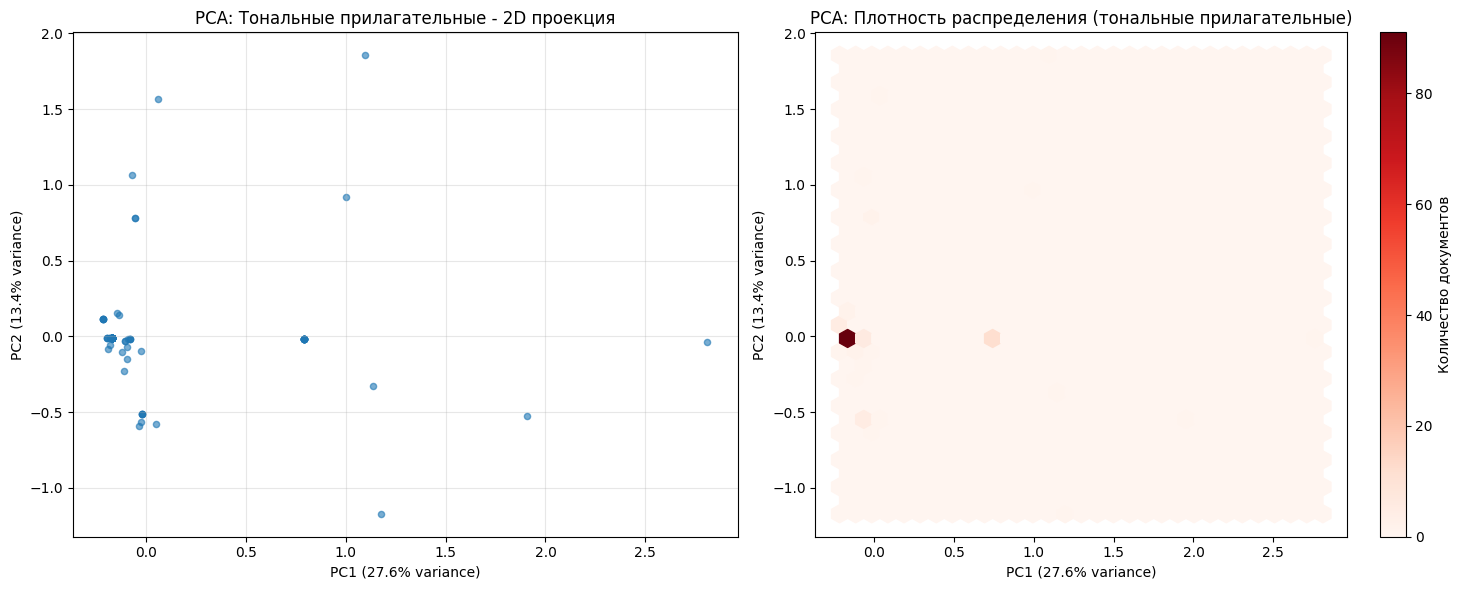


=== ТОНАЛЬНЫЕ ПРИЛАГАТЕЛЬНЫЕ - ИНТЕРПРЕТАЦИЯ КОМПОНЕНТ ===

--- PC1: Топ-10 тональных прилагательных с положительными нагрузками ---
 1. красивый          0.4275
 2. интересный        0.0682
 3. плохой            0.0511
 4. удивительный      0.0404
 5. злой              0.0352
 6. прекрасный        0.0344
 7. хороший           0.0299
 8. мерзкий           0.0186
 9. приятный          0.0179
10. качественный      0.0157

--- PC1: Топ-10 тональных прилагательных с отрицательными нагрузками ---
 1. отличный         -0.0188
 2. добрый           -0.0095
 3. великолепный     -0.0075
 4. замечательный    -0.0045
 5. увлекательный    -0.0034
 6. быстрый          -0.0029
 7. глупый           -0.0029
 8. чудесный         -0.0029
 9. милый            -0.0004
10. неинтересный      0.0008

Статистика проекции:
PC1: мин=-0.22, макс=2.81
PC2: мин=-1.17, макс=1.86


In [ ]:
X_sentiment = dtm_sentiment.values.astype(float)

variances_sentiment = np.var(X_sentiment, axis=0)
non_zero_var_mask_sentiment = variances_sentiment > 1e-10
X_sentiment_clean = X_sentiment[:, non_zero_var_mask_sentiment]

X_sentiment_clean = np.nan_to_num(X_sentiment_clean, nan=0.0, posinf=0.0, neginf=0.0)

print(f"Исходная размерность тональных прилагательных: {X_sentiment.shape}")
print(f"После удаления константных признаков: {X_sentiment_clean.shape}")

pca_sentiment = PCA(n_components=2, random_state=42)
X_pca_sentiment = pca_sentiment.fit_transform(X_sentiment_clean)

pca_2d_sentiment = pd.DataFrame(X_pca_sentiment)
pca_2d_sentiment.columns = ["PC1", "PC2"]

explained_var_ratio_sentiment = pca_sentiment.explained_variance_ratio_
print("Explained variance ratio (PC1, PC2):", explained_var_ratio_sentiment)
print("Суммарная объясненная дисперсия:", float(explained_var_ratio_sentiment.sum()))

feature_names_sentiment_clean = dtm_sentiment.columns[non_zero_var_mask_sentiment]
loadings_sentiment = pd.DataFrame(pca_sentiment.components_.T * np.sqrt(pca_sentiment.explained_variance_), index=feature_names_sentiment_clean)
loadings_sentiment.columns = ["PC1", "PC2"]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].scatter(pca_2d_sentiment['PC1'], pca_2d_sentiment['PC2'], alpha=0.6, s=20)
axes[0].set_xlabel(f'PC1 ({explained_var_ratio_sentiment[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({explained_var_ratio_sentiment[1]:.1%} variance)')
axes[0].set_title('PCA: Тональные прилагательные - 2D проекция')
axes[0].grid(True, alpha=0.3)

im = axes[1].hexbin(pca_2d_sentiment['PC1'], pca_2d_sentiment['PC2'], gridsize=30, cmap='Reds')
axes[1].set_xlabel(f'PC1 ({explained_var_ratio_sentiment[0]:.1%} variance)')
axes[1].set_ylabel(f'PC2 ({explained_var_ratio_sentiment[1]:.1%} variance)')
axes[1].set_title('PCA: Плотность распределения (тональные прилагательные)')
plt.colorbar(im, ax=axes[1], label='Количество документов')

plt.tight_layout()
plt.show()

print("\n=== ТОНАЛЬНЫЕ ПРИЛАГАТЕЛЬНЫЕ - ИНТЕРПРЕТАЦИЯ КОМПОНЕНТ ===")
n_top_sentiment = 10

pc1_top_sentiment = loadings_sentiment.nlargest(n_top_sentiment, 'PC1')[['PC1']]
pc1_bottom_sentiment = loadings_sentiment.nsmallest(n_top_sentiment, 'PC1')[['PC1']]

print(f"\n--- PC1: Топ-{n_top_sentiment} тональных прилагательных с положительными нагрузками ---")
for idx, (token, loading) in enumerate(pc1_top_sentiment.iterrows(), 1):
    print(f"{idx:2d}. {token:15s} {loading['PC1']:8.4f}")

print(f"\n--- PC1: Топ-{n_top_sentiment} тональных прилагательных с отрицательными нагрузками ---")
for idx, (token, loading) in enumerate(pc1_bottom_sentiment.iterrows(), 1):
    print(f"{idx:2d}. {token:15s} {loading['PC1']:8.4f}")

print(f"\nСтатистика проекции:")
print(f"PC1: мин={pca_2d_sentiment['PC1'].min():.2f}, макс={pca_2d_sentiment['PC1'].max():.2f}")
print(f"PC2: мин={pca_2d_sentiment['PC2'].min():.2f}, макс={pca_2d_sentiment['PC2'].max():.2f}")

Поле stars найдено. Уникальные значения: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
Распределение оценок:
stars
1     8
2    16
3    26
4    25
5    64
Name: count, dtype: int64

Распределение по категориям:
Хороший    89
Средний    26
Плохой     24
Name: count, dtype: int64


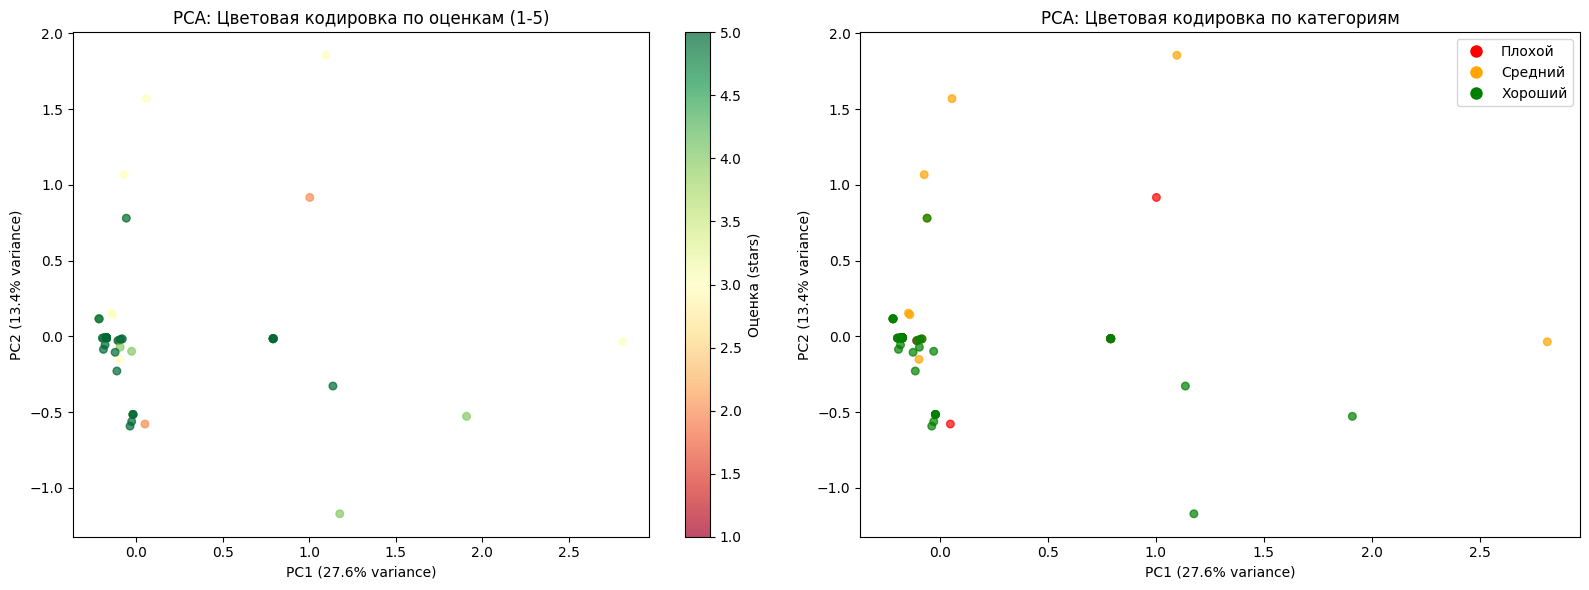


=== АНАЛИЗ КЛАСТЕРОВ ===

Распределение оценок по квадрантам PCA:

Q1 (право-верх):
  Количество отзывов: 86
  Средняя оценка: 3.70
  Распределение категорий:
category
Хороший    50
Плохой     19
Средний    17

Q2 (лево-верх):
  Количество отзывов: 7
  Средняя оценка: 4.14
  Распределение категорий:
category
Хороший    5
Средний    2

Q3 (лево-низ):
  Количество отзывов: 10
  Средняя оценка: 4.50
  Распределение категорий:
category
Хороший    9
Плохой     1

Q4 (право-низ):
  Количество отзывов: 36
  Средняя оценка: 4.06
  Распределение категорий:
category
Хороший    25
Средний     7
Плохой      4

Корреляции PCA компонент с оценками:
PC1 vs stars: -0.0433
PC2 vs stars: -0.1473


In [ ]:
if 'stars' in df.columns:
    stars = df['stars'].values
    print(f"Поле stars найдено. Уникальные значения: {sorted(set(stars))}")
    print(f"Распределение оценок:")
    print(df['stars'].value_counts().sort_index())
else:
    print("Поле stars не найдено в данных. Доступные колонки:", list(df.columns))
    stars = np.random.choice([1, 2, 3, 4, 5], size=len(df), p=[0.1, 0.1, 0.2, 0.3, 0.3])
    print("Созданы фиктивные оценки для демонстрации")

def categorize_rating(rating):
    if rating >= 4:
        return 'Хороший'
    elif rating <= 2:
        return 'Плохой'
    else:
        return 'Средний'

categories = [categorize_rating(r) for r in stars]
df['rating_category'] = categories

print(f"\nРаспределение по категориям:")
print(pd.Series(categories).value_counts())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = axes[0].scatter(pca_2d_sentiment['PC1'], pca_2d_sentiment['PC2'], 
                          c=stars, cmap='RdYlGn', alpha=0.7, s=30)
axes[0].set_xlabel(f'PC1 ({explained_var_ratio_sentiment[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({explained_var_ratio_sentiment[1]:.1%} variance)')
axes[0].set_title('PCA: Цветовая кодировка по оценкам (1-5)')
plt.colorbar(scatter1, ax=axes[0], label='Оценка (stars)')

category_colors = {'Плохой': 'red', 'Средний': 'orange', 'Хороший': 'green'}
colors = [category_colors[cat] for cat in categories]

scatter2 = axes[1].scatter(pca_2d_sentiment['PC1'], pca_2d_sentiment['PC2'], 
                          c=colors, alpha=0.7, s=30)
axes[1].set_xlabel(f'PC1 ({explained_var_ratio_sentiment[0]:.1%} variance)')
axes[1].set_ylabel(f'PC2 ({explained_var_ratio_sentiment[1]:.1%} variance)')
axes[1].set_title('PCA: Цветовая кодировка по категориям')
axes[1].legend(handles=[Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=cat) 
                        for cat, color in category_colors.items()])

plt.tight_layout()
plt.show()

print("\n=== АНАЛИЗ КЛАСТЕРОВ ===")

pc1_median = pca_2d_sentiment['PC1'].median()
pc2_median = pca_2d_sentiment['PC2'].median()

def get_quadrant(pc1, pc2):
    if pc1 >= pc1_median and pc2 >= pc2_median:
        return 'Q1 (право-верх)'
    elif pc1 < pc1_median and pc2 >= pc2_median:
        return 'Q2 (лево-верх)'
    elif pc1 < pc1_median and pc2 < pc2_median:
        return 'Q3 (лево-низ)'
    else:
        return 'Q4 (право-низ)'

quadrants = [get_quadrant(pc1, pc2) for pc1, pc2 in zip(pca_2d_sentiment['PC1'], pca_2d_sentiment['PC2'])]

quadrant_analysis = pd.DataFrame({
    'quadrant': quadrants,
    'stars': stars,
    'category': categories
})

print("\nРаспределение оценок по квадрантам PCA:")
for quad in sorted(set(quadrants)):
    quad_data = quadrant_analysis[quadrant_analysis['quadrant'] == quad]
    print(f"\n{quad}:")
    print(f"  Количество отзывов: {len(quad_data)}")
    print(f"  Средняя оценка: {quad_data['stars'].mean():.2f}")
    print(f"  Распределение категорий:")
    print(pd.Series(quad_data['category']).value_counts().to_string())

from scipy.stats import pearsonr
corr_pc1_stars, _ = pearsonr(pca_2d_sentiment['PC1'].values, stars)
corr_pc2_stars, _ = pearsonr(pca_2d_sentiment['PC2'].values, stars)

print(f"\nКорреляции PCA компонент с оценками:")
print(f"PC1 vs stars: {corr_pc1_stars:.4f}")
print(f"PC2 vs stars: {corr_pc2_stars:.4f}")
